# Profit Analysis
Lo que queremos determinar es si lo efectivamente invertido, corresponde con lo estimado de manera simulada

In [4]:
%load_ext autoreload
%autoreload 2

### Real Profits

In [52]:
from binance.client import Client
import pandas as pd
import numpy as np
import json

In [53]:
from binance.client import Client
import json
with open('secrets/binance.secrets', 'r') as f:
    secrets = json.loads(f.read())
binance_client = Client(api_key=secrets['api_key'], api_secret=secrets['api_secret'])

In [54]:
def get_my_trades(symbol='BTCUSDT'):
    trades = binance_client.get_my_trades(symbol=symbol, recvWindow=59000)
    data = pd.DataFrame(trades)
    data['timestamp'] = pd.to_datetime(data['time'], unit='ms').astype(str)
    data.sort_values('time', inplace=True)
    data.loc[:, 'price'] = data.price.astype(float)
    data.loc[:, 'qty'] = data.qty.astype(float)
    data.loc[:, 'quoteQty'] = data.quoteQty.astype(float)
    data.loc[:, 'commission'] = data.commission.astype(float)
    return data

def weighted_price(x):
    if len(x)==1:
        return x
    else:
        prices = 0
        qtys = 0
        for idx in x.index:
            prices += data.loc[idx, 'price'] * data.loc[idx, 'qty']
            qtys  += data.loc[idx, 'qty']
        return prices/qtys
    
def group_by_orderid(data):
    return data.groupby(['symbol','orderId']).agg({'price':weighted_price,
                                            'qty': sum,
                                            'quoteQty': sum,
                                            'commission': sum,
                                            'commissionAsset':sum,
                                            'timestamp':max,
                                            'isBuyer':max

    }).reset_index()

def trades_to_investments(data):
    data = group_by_orderid(data)
    all_rows = []
    buypart = []
    for i, row in data.iterrows():
        if row.isBuyer:
            if len(buypart)>0:
                all_rows.append(buypart.to_dict())
            buypart = row
            buypart.index=[colname + '_buy' for colname in buypart.index.tolist()]
        else:
            sellpart = row
            sellpart.index=[colname + '_sell' for colname in sellpart.index.tolist()]
            if len(buypart)>0:
                invest = pd.concat([buypart, sellpart])
                buypart = []
            else:
                invest = sellpart
            all_rows.append(invest.to_dict())

    temp = pd.DataFrame(all_rows)

    columns =      ['timestamp_buy', 'symbol_buy', 'price_buy', 'qty_buy',
           'quoteQty_buy', 'commission_buy', 'commissionAsset_buy', 
           'timestamp_sell', 'price_sell', 'qty_sell', 'quoteQty_sell', 
           'commission_sell', 'commissionAsset_sell' 
          ]
    
    return temp[columns]

In [68]:
data = get_my_trades()

In [69]:

#clean up data
data = data.query("time >= 1606543321535 and time < 1607551322477")

In [70]:
data = trades_to_investments(data)

data.loc[:,'pricebased_gain'] = (data.price_sell - data.price_buy)*100/data.price_buy

data.loc[:,'pricebased_gain_adjusted'] = (data.price_sell*0.999 - data.price_buy * 1.001)*100/data.price_buy

data.loc[:,'real_gain'] = (data.quoteQty_sell - data.quoteQty_buy)*100/data.quoteQty_buy

data.loc[:,'real_gain_adjusted'] = (data.quoteQty_sell*0.999 - data.quoteQty_buy)*100/data.quoteQty_buy

data = data.rename(columns={'timestamp_buy':'start_datetime', 'timestamp_sell':'end_datetime'})

In [58]:
data.real_gain_adjusted.sum()

10.095033689844104

In [59]:
data

,timestamp_buy,symbol_buy,price_buy,qty_buy,quoteQty_buy,commission_buy,commissionAsset_buy,timestamp_sell,price_sell,qty_sell,quoteQty_sell,commission_sell,commissionAsset_sell,pricebased_gain,pricebased_gain_adjusted,real_gain,real_gain_adjusted
0,2020-11-28 06:02:01.535,BTCUSDT,16965.14,0.002731,46.331797,0.000003,BTC,2020-11-28 16:02:00.892,17562.07,0.002729,47.926889,0.047927,USDT,3.518568,3.315050,3.442758,3.339315
1,2020-11-28 17:02:01.399,BTCUSDT,17724.81,0.002658,47.112545,0.000003,BTC,2020-11-30 01:01:01.163,18412.26,0.002655,48.884550,0.048795,BNBUSDT,3.878462,3.674583,3.761218,3.657456
2,2020-11-30 02:02:01.279,BTCUSDT,18496.57,0.002594,47.980103,0.000003,BTC,2020-11-30 14:02:00.574,19157.12,0.002591,49.636098,0.049636,USDT,3.571203,3.367631,3.451421,3.347970
3,2020-11-30 15:02:01.793,BTCUSDT,19544.65,0.002498,48.822536,0.000003,BTC,2020-12-01 15:02:00.972,19269.10,0.002496,48.095674,0.048096,USDT,-1.409849,-1.608439,-1.488784,-1.587295
4,2020-12-02 17:01:01.596,BTCUSDT,18872.31,0.002564,48.388603,0.000003,BTC,2020-12-03 16:02:01.198,19543.71,0.002561,50.051441,0.050051,USDT,3.557593,3.354036,3.436426,3.332989
5,2020-12-03 17:02:01.307,BTCUSDT,19365.36,0.002540,49.188014,0.000003,BTC,2020-12-04 08:02:01.005,19298.14,0.002538,48.978679,0.048979,USDT,-0.347115,-0.546768,-0.425581,-0.525156
6,2020-12-05 14:02:01.775,BTCUSDT,18980.83,0.002585,49.065446,0.000003,BTC,2020-12-06 16:02:00.986,19120.63,0.002582,49.369467,0.049369,USDT,0.736533,0.535796,0.619624,0.519004
7,2020-12-07 02:02:00.992,BTCUSDT,19298.25,0.002549,49.191239,0.000003,BTC,2020-12-07 19:02:01.625,18948.16,0.002547,48.260964,0.048261,USDT,-1.814102,-2.012288,-1.891141,-1.989250


## Sim Profits

In [12]:
from core.utils.time_utils import get_minutes_from_interval
import numpy as np
import pandas as pd
from datetime import datetime
import logging
import sys

from core.trade_service.data_manager.data_manager import Data_Manager
from core.trade_service.traders.MA_Trader import MA_Trader

In [33]:
tr = MA_Trader(mode='sim', 
                   symbol='BTCUSDT', 
                   interval_source='1h', 
                   interval_group='1h',
                   period_short=14, 
                   period_long=25,
                   panic=-0.03,
                   start_time=datetime.fromisoformat('2020-11-27 00:00:00')
                  )

In [34]:
tr.evaluate()

2020-11-28 06:00:00 FALSE buy_price 16977.99, current_price 17019.32, gain 0.0024343282096407235
2020-11-28 07:00:00 FALSE buy_price 16977.99, current_price 17014.72, gain 0.0021633891880016164
2020-11-28 08:00:00 FALSE buy_price 16977.99, current_price 16875.01, gain -0.006065500097479336
2020-11-28 09:00:00 FALSE buy_price 16977.99, current_price 16916.42, gain -0.00362645990485348
2020-11-28 10:00:00 FALSE buy_price 16977.99, current_price 17195.73, gain 0.01282483968950376
2020-11-28 11:00:00 FALSE buy_price 16977.99, current_price 17160.29, gain 0.010737431227135795
2020-11-28 12:00:00 FALSE buy_price 16977.99, current_price 17134.42, gain 0.009213693729351746
2020-11-28 13:00:00 FALSE buy_price 16977.99, current_price 17356.02, gain 0.022265886597883425
2020-11-28 14:00:00 FALSE buy_price 16977.99, current_price 17336.07, gain 0.021090835840991664
2020-11-28 15:00:00 FALSE buy_price 16977.99, current_price 17517.04, gain 0.03174993035100146
2020-11-28 16:00:00 FALSE buy_price 169

In [46]:
trade_data = pd.DataFrame(tr.trade_record).T

In [47]:
trade_data.loc[:, 'gain'] = trade_data.apply(
                lambda row: (row.end_price - row.start_price) * 100 / row.start_price,
                axis=1)

In [48]:
tr.score(1,1)

13.107567861428649

In [49]:
trade_data

,start_datetime,start_price,end_datetime,end_price,gain
0,2020-11-28 05:00:00,16978,2020-12-01 14:00:00,19285.3,13.590066
1,2020-12-02 16:00:00,18856.2,2020-12-04 07:00:00,19283.9,2.268160
2,2020-12-05 13:00:00,18983.1,2020-12-06 15:00:00,19125.8,0.751720
3,2020-12-07 01:00:00,19293.1,2020-12-07 18:00:00,18939.7,-1.831641
4,2020-12-09 21:00:00,18519.4,2020-12-10 12:00:00,18210,-1.670737


In [37]:
from core.analitics.basic_plots import plot_line_buysell, to_pandas
import matplotlib.pylab as pl
import matplotlib.pyplot as plt


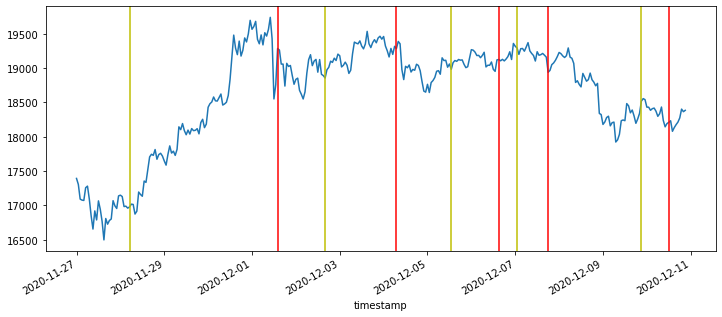

In [38]:
plot_line_buysell(tr)

In [43]:
month = 11

def plot_line(model):
    result_pd = to_pandas(model)
    result_pd = result_pd[result_pd.start_datetime.dt.month >= month]

    data = model.get_data()
    data.loc[:,'malong'] = model.ma_long.evaluate(data)
    data.loc[:,'mashort'] = model.ma_short.evaluate(data)
    data = data[data.index.month>=month]
    data.close.plot(figsize=(20,10), color='black')
    data.mashort.plot(marker='.', color='r', alpha=.2)
    data.malong.plot(marker='.', color='b', alpha=.2)
    for init, end in zip(result_pd.start_datetime, result_pd.end_datetime):
        pl.axvline(init, color='y')
        pl.axvline(end, color='r')

        plt.title('Period gain: {}'.format(result_pd.gan.sum()))

/Users/gsidoni/anaconda3/envs/cyptotrade/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/gsidoni/anaconda3/envs/cyptotrade/lib/python3.8/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


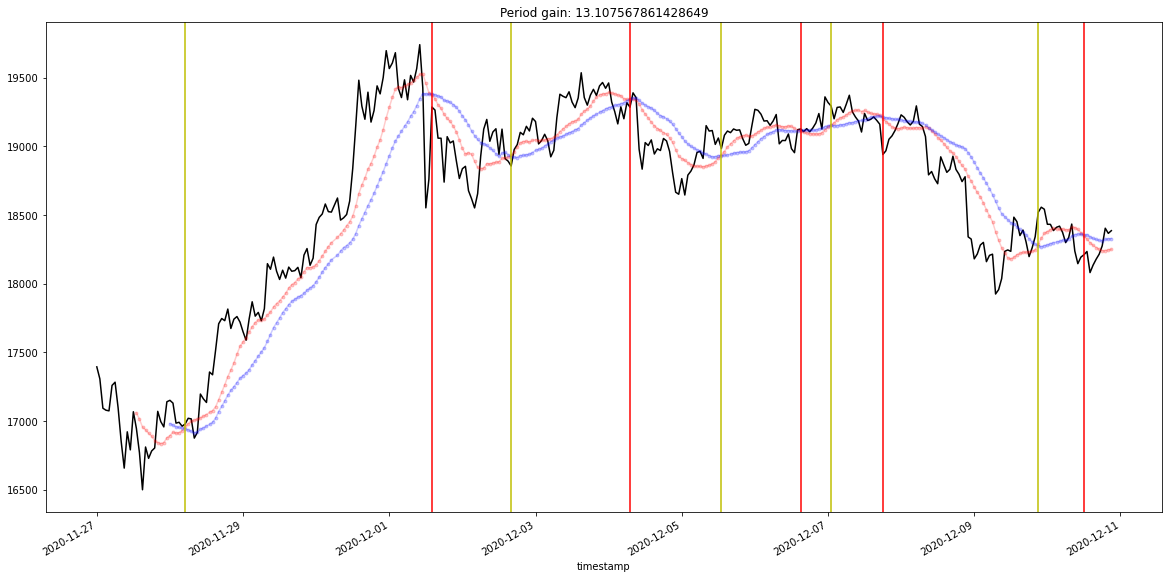

In [44]:
plot_line(tr)

In [50]:
data

NameError: name 'data' is not defined

In [75]:
month = 11

def plot_line(model, result_pd):
    data = model.get_data()
    data.loc[:,'malong'] = model.ma_long.evaluate(data)
    data.loc[:,'mashort'] = model.ma_short.evaluate(data)
    data = data[data.index.month>=month]
    data.close.plot(figsize=(20,10), color='black')
    data.mashort.plot(marker='.', color='r', alpha=.2)
    data.malong.plot(marker='.', color='b', alpha=.2)
    for init, end in zip(result_pd.start_datetime, result_pd.end_datetime):
        pl.axvline(init, color='y')
        pl.axvline(end, color='r')

        plt.title('Period gain: {}'.format(result_pd.real_gain.sum()))

/Users/gsidoni/anaconda3/envs/cyptotrade/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/gsidoni/anaconda3/envs/cyptotrade/lib/python3.8/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


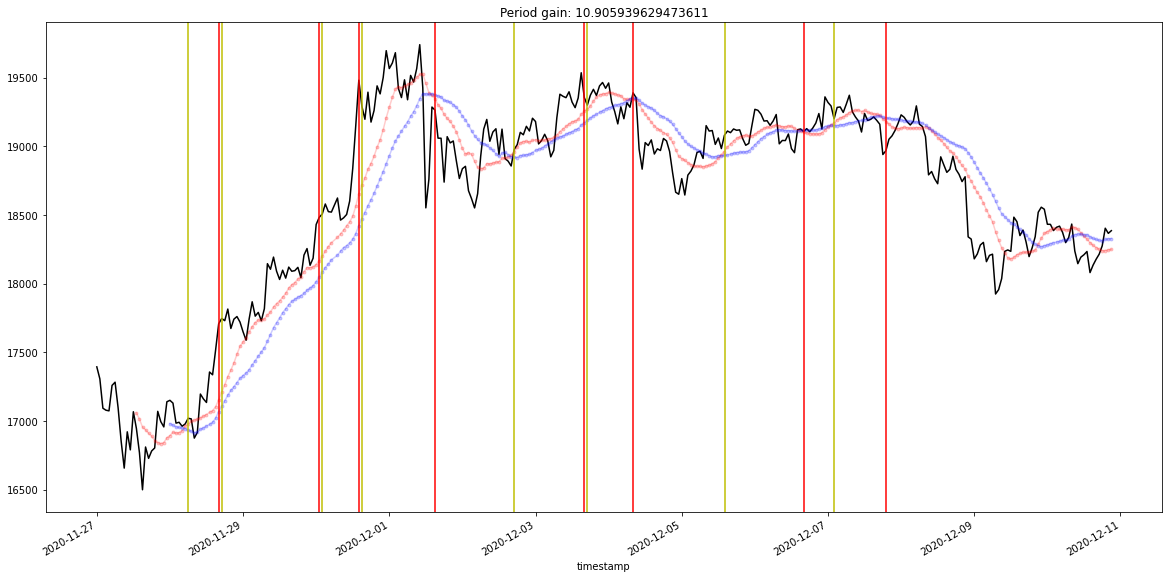

In [76]:
plot_line(tr, data)